In [1]:
import neuralnet as nn
import matplotlib.pyplot as plt
import numpy as np
import pickle
import time
np.random.seed(123)

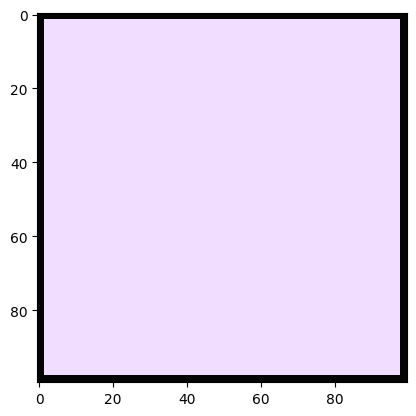

In [2]:
data = np.ones((100,100,5))
out = nn.convolve(data, 5, 3).astype(float)
plt.imshow(out / np.max(out))